In [2]:

# --------------------------------------------------------
# pip install pandas numpy scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

Dataset shape: (15509, 10)
                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi) -2019.0  109 min            Drama   
2                         #Homecoming -2021.0   90 min   Drama, Musical   
3                             #Yaaram -2019.0  110 min  Comedy, Romance   
4                   ...And Once Again -2010.0  105 min            Drama   

   Rating Votes            Director       Actor 1             Actor 2  \
0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   

           Actor 3  
0  Rajendra Bhatia  
1    Arvind Jangid  
2       Roy Angana  

/tmp/ipython-input-2168567744.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['runtime'].fillna(df['runtime'].median(), inplace=True)


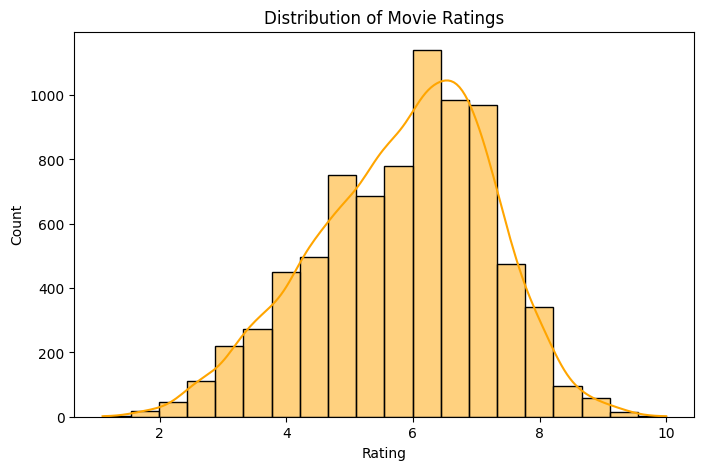

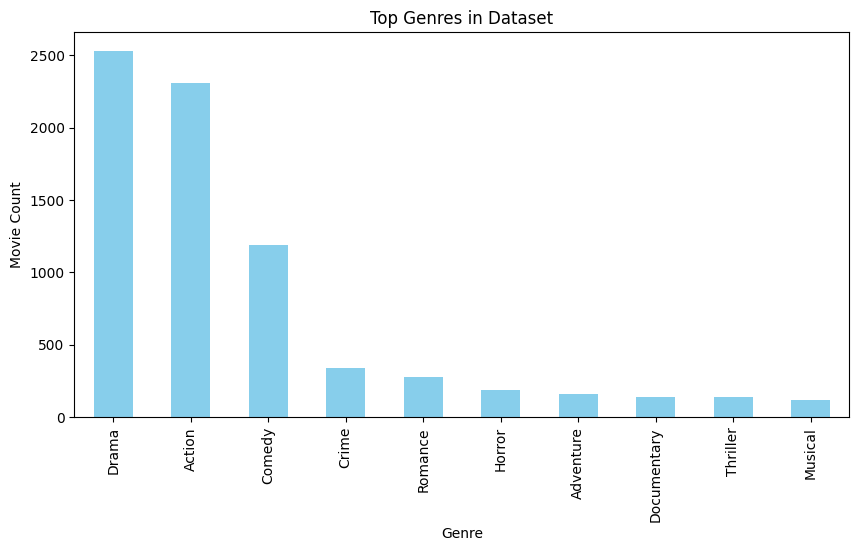

/tmp/ipython-input-2168567744.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='main_genre', y='vote_average', data=df, palette='Set2')


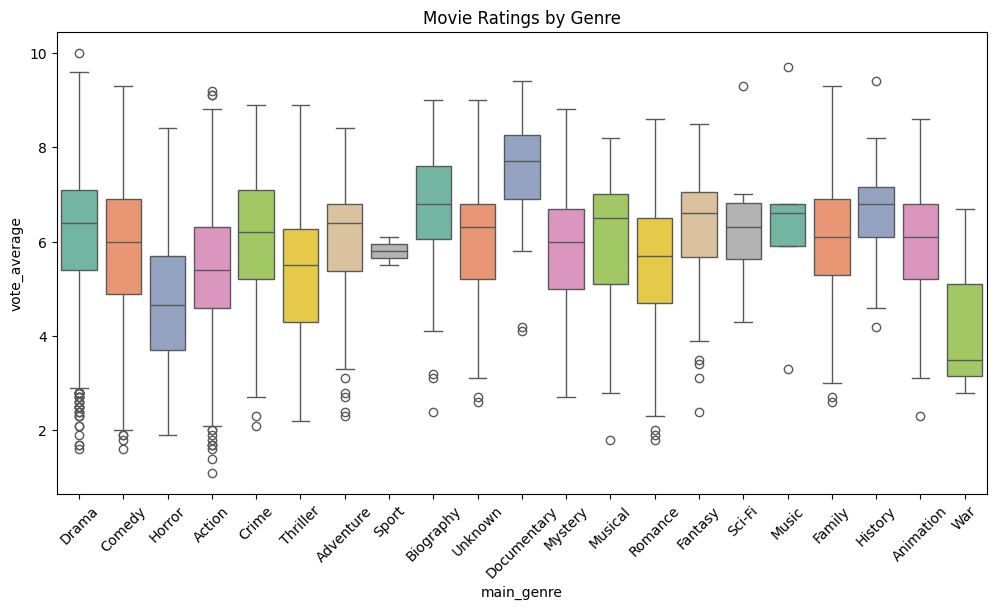

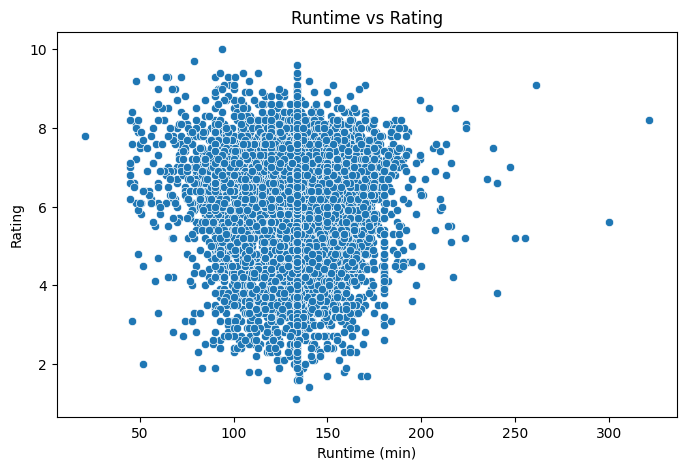

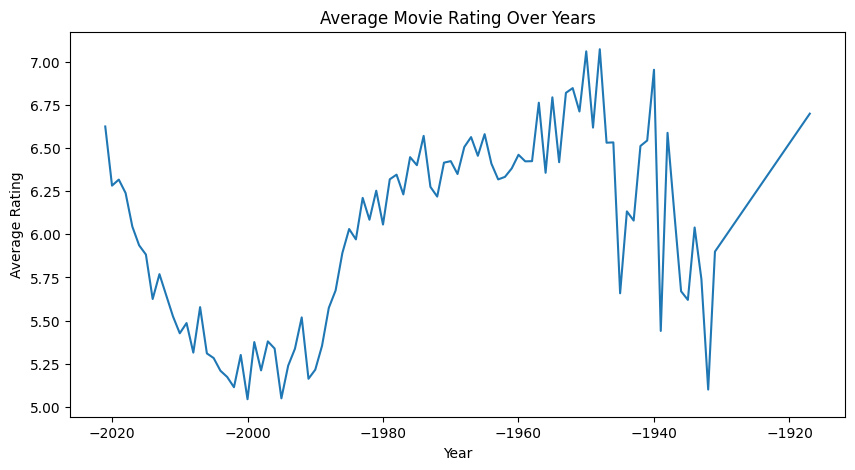


Model Performance:
                        MAE      RMSE        R2
Linear Regression  0.997301  1.257200  0.149850
Ridge Regression   0.996674  1.256295  0.151073
Random Forest      1.031737  1.331297  0.046684
XGBoost            0.962977  1.240493  0.172296


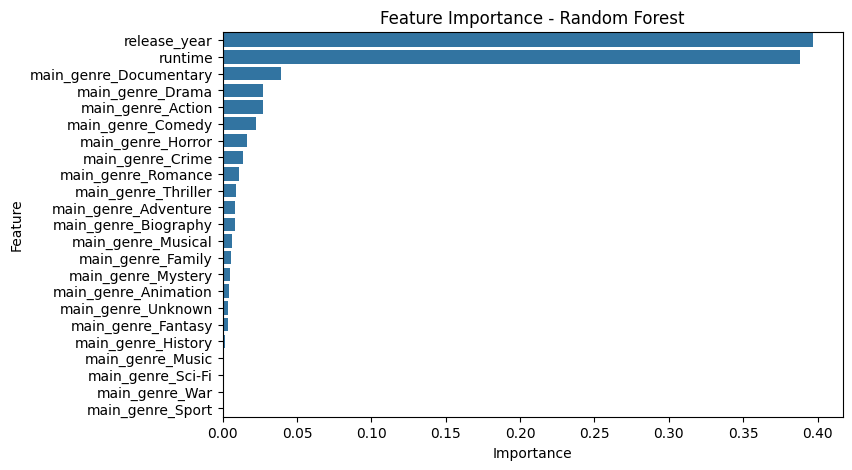

In [5]:
# --------------------------------------------------------
# 1️⃣ Install required packages (if not installed)
# --------------------------------------------------------
# pip install pandas numpy scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# --------------------------------------------------------
# 2️⃣ Load Dataset (TMDB 5000 Movies Example)
# --------------------------------------------------------
# Try different encodings to handle potential UnicodeDecodeError
try:
    df = pd.read_csv("/content/IMDb Movies India.csv", encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv("/content/IMDb Movies India.csv", encoding='latin1')
    except UnicodeDecodeError:
        df = pd.read_csv("/content/IMDb Movies India.csv", encoding='ISO-8859-1')

print("Dataset shape:", df.shape)
print(df.head())

# --------------------------------------------------------
# 3️⃣ Data Cleaning
# --------------------------------------------------------
# Update column selection based on actual column names
df = df[['Name', 'Genre', 'Duration', 'Rating', 'Year']]

# Rename columns to match expected names
df = df.rename(columns={'Name': 'title',
                        'Genre': 'genres',
                        'Duration': 'runtime',
                        'Rating': 'vote_average',
                        'Year': 'release_year'})


# Drop rows where target is missing
df = df.dropna(subset=['vote_average'])

# Convert release year to numeric, coercing errors to NaN
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
df = df.dropna(subset=['release_year']) # Drop rows where release year is missing after coercion

# Extract first genre (assuming genres are comma-separated strings)
def extract_first_genre(x):
    if isinstance(x, str) and len(x) > 0:
        return x.split(',')[0].strip()
    else:
        return "Unknown"

df['main_genre'] = df['genres'].apply(extract_first_genre)

# Convert runtime to numeric, coercing errors and handling missing values
df['runtime'] = df['runtime'].str.replace(' min', '', regex=False)
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df['runtime'].fillna(df['runtime'].median(), inplace=True)

# Handle missing numeric values (budget is missing in this dataset, so we won't use it)
# df['budget'] = df['budget'].replace(0, np.nan)
# df['budget'].fillna(df['budget'].median(), inplace=True)


# --------------------------------------------------------
# 4️⃣ EDA - Exploratory Data Analysis
# --------------------------------------------------------

print("\nBasic Info:")
print(df.info())

print("\nDescriptive Stats:")
print(df.describe())

# Distribution of target variable
plt.figure(figsize=(8,5))
sns.histplot(df['vote_average'], bins=20, kde=True, color='orange')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Genre distribution
plt.figure(figsize=(10,5))
df['main_genre'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top Genres in Dataset")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.show()

# Ratings by genre
plt.figure(figsize=(12,6))
sns.boxplot(x='main_genre', y='vote_average', data=df, palette='Set2')
plt.title("Movie Ratings by Genre")
plt.xticks(rotation=45)
plt.show()

# Budget vs Rating (Budget is not available in this dataset, skipping)
# plt.figure(figsize=(8,5))
# sns.scatterplot(x='budget', y='vote_average', data=df)
# plt.title("Budget vs Rating")
# plt.xlabel("Budget (USD)")
# plt.ylabel("Rating")
# plt.show()

# Runtime vs Rating
plt.figure(figsize=(8,5))
sns.scatterplot(x='runtime', y='vote_average', data=df)
plt.title("Runtime vs Rating")
plt.xlabel("Runtime (min)")
plt.ylabel("Rating")
plt.show()

# Release Year Trends
yearly_avg = df.groupby('release_year')['vote_average'].mean()
plt.figure(figsize=(10,5))
yearly_avg.plot()
plt.title("Average Movie Rating Over Years")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()

# --------------------------------------------------------
# 5️⃣ Feature & Target Definition
# --------------------------------------------------------
X = df[['runtime', 'release_year', 'main_genre']] # Removed budget
y = df['vote_average']

# --------------------------------------------------------
# 6️⃣ Preprocessing
# --------------------------------------------------------
numeric_features = ['runtime', 'release_year'] # Removed budget
categorical_features = ['main_genre']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# --------------------------------------------------------
# 7️⃣ Train-Test Split
# --------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------------------
# 8️⃣ Train Multiple Models
# --------------------------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

results_df = pd.DataFrame(results).T
print("\nModel Performance:")
print(results_df)

# --------------------------------------------------------
#
# --------------------------------------------------------
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=200, random_state=42))])
rf_pipeline.fit(X_train, y_train)

feature_names = (numeric_features +
                 list(rf_pipeline.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))

importances = rf_pipeline.named_steps['model'].feature_importances_

feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title("Feature Importance - Random Forest")
plt.show()